In [ ]:
!pip install --upgrade networkx

!pip install --upgrade mxnet
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=137367f1c63c78d4eabe0c9170d03e1b0bbb73ebff827a1be7476dc3c876c544
  Stored in directory: /root/.cache/pip/wheels/ea/f9/a1/34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Succ

In [ ]:

!pip install mxnet-cu112

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.0 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
import anvil.server


In [ ]:

NUM_NODE = 50
WEIGHT_MIN = .5
WEIGHT_MAX = 1.
const_list=[]
for i in range(15):
  flag=True
  while flag:
    index = random.randint(0, 49)
    if index not in const_list:
      const_list.append(index)
      flag=False


In [ ]:

def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=50,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    num_of_passengers=0
    #dx=1/grid_size=1/20,000=0.00005
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)#[0.00000,0.00005,...,0.99995]
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)#permutated list of numbers from 0 to 20,000
    x_coords = euclidean_coords[coords_indices][:num_nodes]#permutated subset of euclidean_coords
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]#permutated subset of euclidean_coords
#     print(y_coords)
    
    # Add coordinates to nodes
    #(make nodes: set coordinites and define number of passengers from node to node)
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        
        amount=random.randrange(0,20,5)#number of passengers from the node
                                         
        num_of_passengers+=amount
        #nodes of distinations
        pdist=[0]*amount
        for i in range(amount):
          while True:
            pdist[i]=random.randint(0,len(x_coords))
            if pdist[i]!=coord[0]:
                break
              
        G.add_node(node, x=coord[0], y=coord[1],passengers=amount,dists=pdist)
    

    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])#list of other nodes odered by distance from this node
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)

        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                continue
            passengers=G.nodes[tmp_node[0]]['passengers']+G.nodes[node]['passengers']
            if tmp_node in const_list:
              weight= 0.3
            else:
              if passengers>=0 and passengers <=10:
                weight=0.9
              elif  passengers >10 and passengers <=20:
                weight =0.7
              elif passengers >20 and passengers <=30 :
                weight=0.5
              else:
                weight =1

            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
    print(num_of_passengers)
    return G

350
325
350
4
2
50
86
the nodes are : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


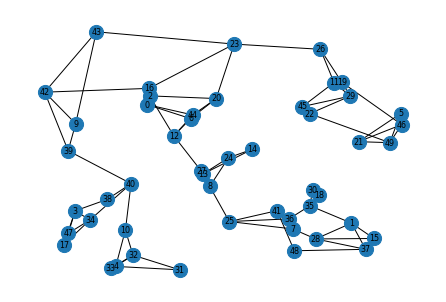

In [ ]:


G = generate_low_degree_g()
while nx.is_connected(G)==False:
  G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
print(f"the nodes are : {G.nodes}")
pos = {}
x=G.number_of_nodes
for t in G.nodes:
        pos[t] = (G.nodes[t]['x'], G.nodes[t]['y'])

nx.draw(G, pos=pos, node_size=200, font_size=8, with_labels=True)
plt.show()

In [ ]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, num_train_node_pairs=400,\
                                    num_test_node_pairs=100, verbose_frequence=100):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

In [ ]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
    return X_aug, y_aug

In [ ]:
def generate_samples_from_graph(num_node_pairs, graph_size=50, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    while nx.is_connected(G) == False:
      G = generate_low_degree_g()
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
    assert len(X) == len(y)
    
    print(label)
    print("%d pairs are selected for training" % (len(selected_pairs)))
    print("len of pair_path_dict: %d" % (len(pair_path_dict)))
    print("Num of training sample: %d" % len(y))
    print(label)
    print('\n')
    
    return X, y, G, pair_path_dict

In [ ]:
X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=1000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=100, augmentation=False, label='Validation')

355


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Train
1000 pairs are selected for training
len of pair_path_dict: 1000
Num of training sample: 62140
Train


400
Validation
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 550
Validation




In [ ]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

In [ ]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=2048)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=1024)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    fc2 = mx.sym.Dropout(data=fc2)
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50) 

/usr/local/lib/python3.8/dist-packages/mxnet/module/base_module.py:501: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  self.init_params(initializer=initializer, arg_params=arg_params, aux_params=aux_params,
INFO:root:Epoch[0] Batch [0-200]	Speed: 16085.00 samples/sec	accuracy=0.812228
INFO:root:Epoch[0] Batch [200-400]	Speed: 25426.78 samples/sec	accuracy=0.850234
INFO:root:Epoch[0] Train-accuracy=0.834185
INFO:root:Epoch[0] Time cost=3.236
INFO:root:Epoch[0] Validation-accuracy=0.801562
INFO:root:Epoch[1] Batch [0-200]	Speed: 26347.81 samples/sec	accuracy=0.860580
INFO:root:Epoch[1] Batch [200-400]	Speed: 26989.59 samples/sec	accuracy=0.865078
INFO:root:Epoch[1] Train-accuracy=0.862703
INFO:root:Epoch[1] Time cost=2.308
INFO:root:Epoch[1] Validation-accuracy=0.834375
INFO:root:Epoch[2] Batch [0-200]	Speed: 25558.47 samples/sec	accuracy=0.871113
INFO:root:Epoch[2] Batch [200-400]	Speed: 26657.85 samples/sec	accuracy=0.869336
INFO:root:Epoc

In [ ]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=200, graph_size=50, augmentation=False, augmentation_index=1, label='Test')
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)
acc = accuracy_score(y_test, pred_test)
print("Accuracy on test set: %f" % (acc))

370
Test
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 1162
Test


Accuracy on test set: 0.888985


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


In [ ]:

graph_sizes = [50, 100, 150]
stats = [[] for _ in range(len(graph_sizes))]
sample_size_stats = [[] for _ in range(len(graph_sizes))]
number_of_tests = 50
num_node_pairs = 300

In [ ]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
        
        if i > 0 and i % 5 == 0:
            print("Processed %d graphs" % i)
            
        X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=num_nodes, augmentation=False, label='Test')

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)
        sample_size_stats[idx].append(len(y_test))

Working on graphs with 50 nodes
400


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1542
Test


405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1698
Test


335


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1978
Test


375


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1658
Test


465


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2172
Test


Processed 5 graphs
345


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1624
Test


355
335


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1452
Test


410
330
420


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1622
Test


385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1618
Test


365
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1728
Test


Processed 10 graphs
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1612
Test


385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2076
Test


335
325


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1576
Test


395
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1588
Test


320


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1662
Test


Processed 15 graphs
380
370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2158
Test


410


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1558
Test


450


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1676
Test


350


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1896
Test


395


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1696
Test


Processed 20 graphs
380
400
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1870
Test


370
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1630
Test


420


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1510
Test


385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1902
Test


405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1702
Test


Processed 25 graphs
400


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1846
Test


360


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1580
Test


370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1856
Test


325


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1776
Test


305


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1680
Test


Processed 30 graphs
360


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2404
Test


440


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2532
Test


440


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1592
Test


360


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1840
Test


340


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1772
Test


Processed 35 graphs
330


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2488
Test


345


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2048
Test


385
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1838
Test


430
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1892
Test


365
395


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1652
Test


Processed 40 graphs
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1942
Test


370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1552
Test


265
310
405


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1626
Test


355


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1894
Test


290


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1762
Test


Processed 45 graphs
300


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2288
Test


385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1890
Test


340


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2046
Test


390
430


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1650
Test


350


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1700
Test


Working on graphs with 100 nodes
655
450


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1996
Test


765


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3100
Test


785
430


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1644
Test


705
330


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1738
Test


670


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2572
Test


Processed 5 graphs
670
420


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1846
Test


725


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2590
Test


775


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2176
Test


655
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1846
Test


655


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2476
Test


Processed 10 graphs
770


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2792
Test


700


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2824
Test


790
430


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1990
Test


840
415
360


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1866
Test


720


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2670
Test


Processed 15 graphs
740


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2560
Test


750


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3616
Test


800


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2558
Test


685


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2616
Test


710
310


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1982
Test


Processed 20 graphs
795
375


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2886
Test


810


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2802
Test


765


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3482
Test


710


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3414
Test


815


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3250
Test


Processed 25 graphs
700
335


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


370
Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1860
Test


650


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2776
Test


665


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3134
Test


800


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2572
Test


705


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2532
Test


Processed 30 graphs
745


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2776
Test


680


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3352
Test


770
325


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2208
Test


825


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2538
Test


785


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3160
Test


Processed 35 graphs
745
365


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1778
Test


770
360
325
390
305


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2032
Test


710
350
340


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1980
Test


820


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3132
Test


685


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2530
Test


Processed 40 graphs
725


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3146
Test


740
365


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2342
Test


785


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3244
Test


695
410


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


385
Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1686
Test


685


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2578
Test


Processed 45 graphs
780


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3100
Test


795


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2770
Test


725


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3588
Test


730


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2838
Test


825
395


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2022
Test


Working on graphs with 150 nodes
1130
370
400
385
385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1614
Test


1080
365
415


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1698
Test


1225
370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1834
Test


1220


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3774
Test


1085


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3536
Test


Processed 5 graphs
1285


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3852
Test


1090


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3002
Test


1105


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3398
Test


1065
340
355


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2190
Test


1215


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3638
Test


Processed 10 graphs
1165


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3044
Test


1010
380
320
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2218
Test


1165


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3266
Test


1035


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3298
Test


1025


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3072
Test


Processed 15 graphs
1100
390


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1990
Test


1140


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3314
Test


1120
370
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1580
Test


1025
365


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1634
Test


1180


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3822
Test


Processed 20 graphs
1185
365


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1936
Test


1220
450
420


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1552
Test


1205
440
350
400


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1766
Test


1005


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3770
Test


1055
340
365


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2218
Test


Processed 25 graphs
1190


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3014
Test


1140


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3514
Test


1105


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3424
Test


1000


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3230
Test


1315


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3768
Test


Processed 30 graphs
1295


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3254
Test


1235


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 4814
Test


1165


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3386
Test


1105
390


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1924
Test


1160


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3574
Test


Processed 35 graphs
1095
350


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1722
Test


1160


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3946
Test


1265


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3646
Test


1060
415


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1912
Test


1095
390


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


310
Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2420
Test


Processed 40 graphs
1050


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3628
Test


1055


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3786
Test


1135


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3152
Test


1080
435


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1612
Test


1090
385


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2124
Test


Processed 45 graphs
1120
370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 2284
Test


1080
410
370


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1632
Test


1195
380


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 1880
Test


1295


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3110
Test


1185


<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Test
300 pairs are selected for training
len of pair_path_dict: 300
Num of training sample: 3834
Test




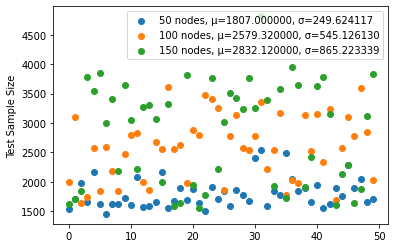

In [ ]:
for idx, stat in enumerate(sample_size_stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Test Sample Size")
plt.legend(loc='best')
plt.show()

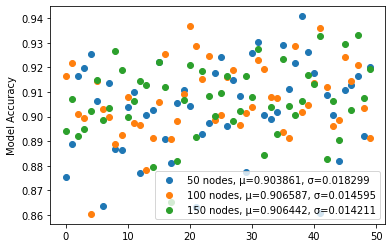

In [ ]:
for idx, stat in enumerate(stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Model Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model, real_time_weight=False):

    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    assert max_degree == 4
    real_time_weight_change_factors = np.array([random.expovariate(lambd=1.0)\
                                                for _ in range(max_degree)])\
                                if real_time_weight else np.ones(max_degree)
    
    input_vec[:, 1] = np.multiply(input_vec[:, 1], real_time_weight_change_factors)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        l=list(avaliable_neighbors)
        neighbor = int(l[np.random.randint(0, len(l))])
            
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, p=0.0, model=None,\
                         invalid_path_threshold=G.number_of_nodes(),
                         real_time_weight=False):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        neigbors = list(G.neighbors(cur_node))
        num_neighbors = len(neigbors)
        
        pred_next_node, _ = nn_infer_next_node(G, path, parent_node,\
                                               cur_node, src, dst, model,\
                                               real_time_weight=real_time_weight)
        pred_next_idx = neigbors.index(pred_next_node)
        
        sample_probabilities = [p/(num_neighbors-1)\
                                for _ in range(num_neighbors)]
        sample_probabilities[pred_next_idx] = 1-p
        assert sum(sample_probabilities) <= 1.0
        
        next_node = np.random.choice(neigbors, 1, p=sample_probabilities)[0]
        total_weights += G.get_edge_data(cur_node, next_node)['weight']
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [ ]:
def calc_path_weight_sum(G, path):
    
    weight_sum = 0.0
    
    for idx, node in enumerate(path[:-1]):
        weight_sum += G.edges[(node, path[idx + 1])]['weight']
        
    return weight_sum

In [ ]:
def calc_statistics(G, pair_path_dict, num_to_test=100, verbose=True):
    found_cnt = 0
    opt_path_cnt = 0
    edge_efficiency = {}
    time_efficiency = {}

    keys =  list(pair_path_dict.keys())

    
    for key in keys:
        nn_path, _, found = dijkstra_path_finder(G, key[0], key[1], model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(key[0],key[1])]
        
        if not found:
            
            continue

        found_cnt += 1
        for i in range(len(nn_path)-1):
          index=-1
          index1=i
          for j in range(i+1,len(nn_path)-1):
            
            if nn_path[i]==nn_path[j]:
              index=j
          if index !=-1:
           print(index," ",index1," ",len(nn_path))    
           del nn_path[index1:index]
           

        edge_efficiency[(key[0], key[1])] = float(len(dijkstra_path)-1) / (len(nn_path)-1)
        time_efficiency[(key[0], key[1])] = calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, nn_path)
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1
        else:
            if verbose:
                print("The model is able to find a different path between %d and %d" % (key[0], key[1]))
                plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
                print("Dijkstra path :", dijkstra_path)
                print("NN path :", nn_path)
                print('')



    return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

In [ ]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100, verbose=True):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G,\
                                                                pair_path_dict=pair_path_dict,\
                                                                num_to_test=num_to_test,
                                                                verbose=verbose)
    arrival_rate=float(found_cnt)/num_total_path
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, arrival_rate))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
    edge_efficiency_values = list(edge_efficiency.values())##########################added list
    stat_mean = np.mean(edge_efficiency_values)
    stat_std = np.std(edge_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(edge_efficiency), stat_mean, stat_std)
    print(label)
    edge_eff=stat_mean
    time_efficiency_values = list(time_efficiency.values())
    stat_mean = np.mean(time_efficiency_values)
    stat_std = np.std(time_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(time_efficiency), stat_mean, stat_std)
    time_eff=stat_mean
    print(label)
    overall_eff=(0.5 * arrival_rate) + (0.3* time_eff) + (0.2*edge_eff)
    print("Overall efficiency= ",overall_eff)

In [ ]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])

    plt.legend(loc='best')
    plt.show()

In [ ]:
model.save_params("/content/drive/MyDrive/project3/model")

In [ ]:
batch_size=128
for i in range(10):

  X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=1000, augmentation=True, augmentation_index=10, label='Train')
  X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=100, augmentation=False, label='Validation')

  train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
  val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)


  model.load_params("/content/drive/MyDrive/project3/model")
  model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50)
  model.save_params("/content/drive/MyDrive/project3/model") 

NameError: ignored

365
Test
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 650
Test




<ipython-input-8-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


The model is able to find a different path between 17 and 18


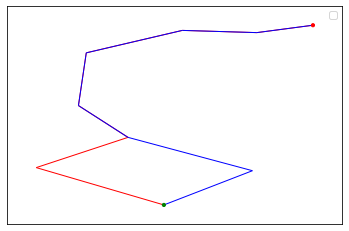

Dijkstra path : [17, 14, 35, 47, 40, 10, 5, 18]
NN path : [17, 14, 35, 47, 40, 10, 12, 18]



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


The model is able to find a different path between 41 and 36


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


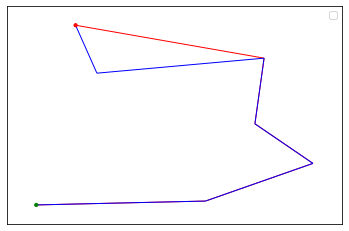

Dijkstra path : [41, 47, 40, 10, 5, 36]
NN path : [41, 21, 47, 40, 10, 5, 36]

The model is able to find a different path between 36 and 41


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


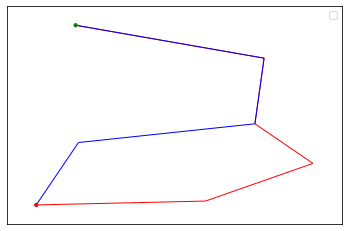

Dijkstra path : [36, 5, 10, 40, 47, 41]
NN path : [36, 45, 40, 47, 41]



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


The model is able to find a different path between 44 and 13


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


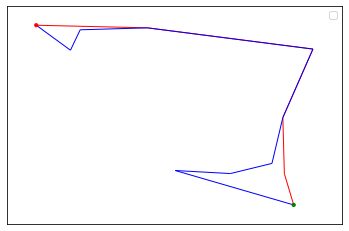

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [44, 0, 25, 20, 4, 13]
NN path : [44, 28, 31, 0, 25, 20, 17, 14, 35, 13]

The model is able to find a different path between 13 and 44


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


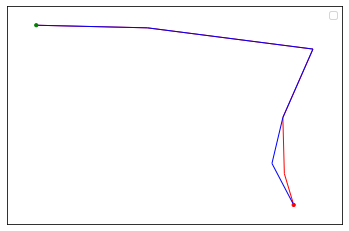

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [13, 4, 20, 25, 0, 44]
NN path : [13, 17, 20, 25, 0, 44]

The model is able to find a different path between 10 and 4


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


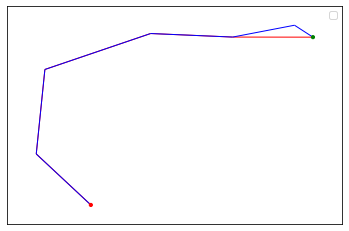

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [10, 40, 47, 35, 14, 4]
NN path : [10, 40, 47, 35, 14, 17, 4]

The model is able to find a different path between 38 and 21


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


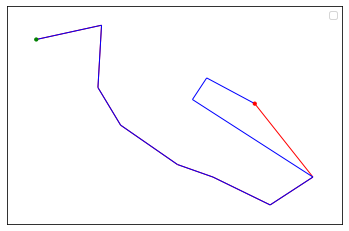

Dijkstra path : [38, 43, 19, 7, 12, 10, 40, 47, 21]
NN path : [38, 39, 27, 43, 19, 7, 12, 10, 40, 47, 21]

19   3   21


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


The model is able to find a different path between 42 and 11


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


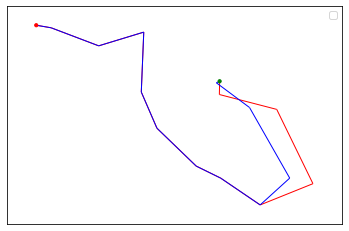

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [42, 9, 21, 47, 40, 10, 12, 7, 19, 22, 33, 26, 11]
NN path : [42, 9, 21, 47, 40, 10, 12, 7, 19, 43, 38, 39, 11]

The model is able to find a different path between 8 and 24


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


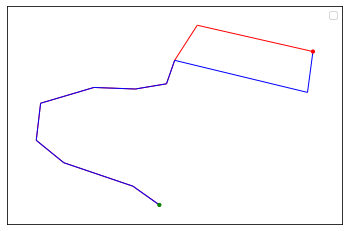

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [8, 25, 20, 17, 14, 35, 47, 40, 10, 12, 24]
NN path : [8, 37, 20, 17, 14, 35, 47, 40, 10, 12, 24]

The model is able to find a different path between 24 and 8


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


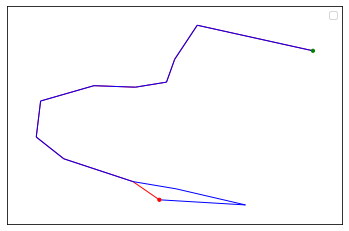

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [24, 12, 10, 40, 47, 35, 14, 17, 20, 25, 8]
NN path : [24, 19, 7, 12, 10, 40, 47, 35, 14, 17, 20, 25, 8]

The model is able to find a different path between 30 and 12


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


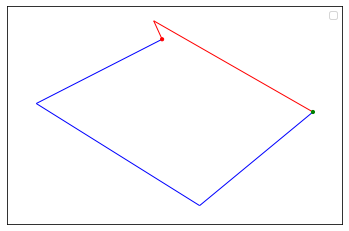

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [30, 10, 12]
NN path : [30, 5, 18, 12]

The model is able to find a different path between 27 and 49


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


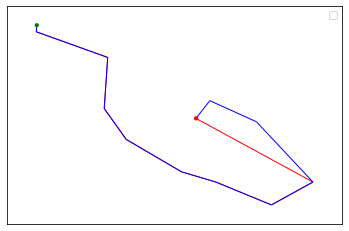

Dijkstra path : [27, 43, 19, 7, 12, 10, 40, 47, 41, 49]
NN path : [27, 39, 38, 43, 19, 7, 12, 10, 40, 47, 41, 49]

The model is able to find a different path between 30 and 33


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


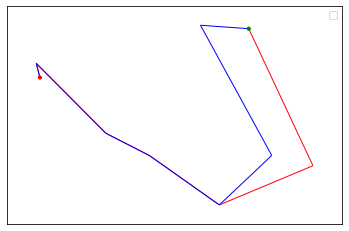

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [30, 10, 12, 7, 19, 22, 33]
NN path : [30, 10, 12, 7, 19, 43, 38, 33]

The model is able to find a different path between 33 and 30


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


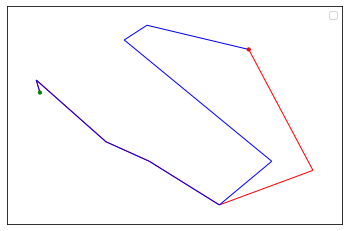

Dijkstra path : [33, 22, 19, 7, 12, 10, 30]
NN path : [33, 26, 27, 43, 19, 7, 12, 10, 30]

25   1   32
The model is able to find a different path between 24 and 11


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


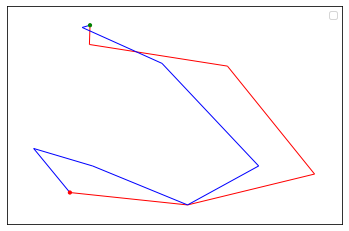

Dijkstra path : [24, 19, 22, 33, 26, 11]
NN path : [24, 12, 7, 19, 43, 38, 39, 11]

The model is able to find a different path between 46 and 1


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


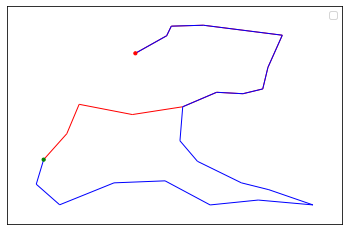

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 21, 9, 23, 1]
NN path : [46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10, 12, 7, 19, 24, 18, 5, 36, 6, 29, 1]

The model is able to find a different path between 17 and 15


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


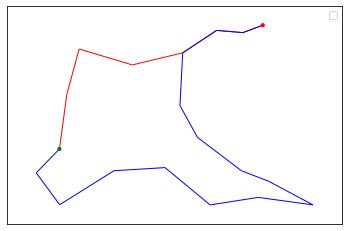

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [17, 14, 35, 47, 21, 9, 23, 15]
NN path : [17, 14, 35, 47, 40, 10, 12, 7, 19, 24, 18, 5, 36, 6, 29, 15]

The model is able to find a different path between 39 and 33


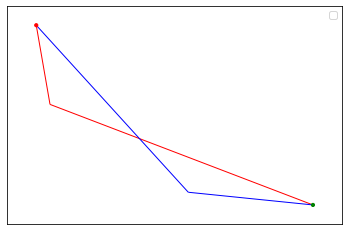

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [39, 26, 33]
NN path : [39, 38, 33]

The model is able to find a different path between 33 and 39


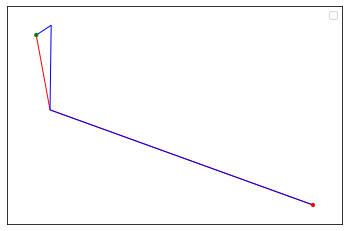

Dijkstra path : [33, 26, 39]

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved



NN path : [33, 26, 11, 39]

The model is able to find a different path between 34 and 15


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


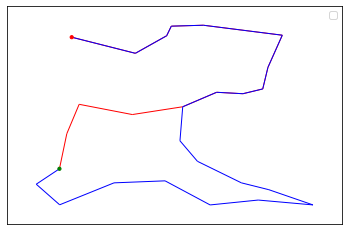

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [34, 46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 21, 9, 23, 15]
NN path : [34, 46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10, 12, 7, 19, 24, 18, 5, 36, 6, 29, 15]

22   4   33
The model is able to find a different path between 41 and 32


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


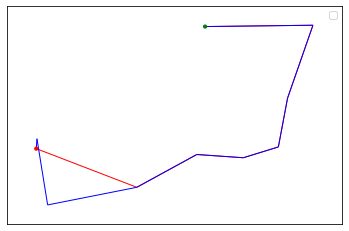

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [41, 47, 35, 14, 17, 20, 25, 32]
NN path : [41, 49, 21, 47, 35, 14, 17, 20, 25, 32]

The model is able to find a different path between 32 and 41


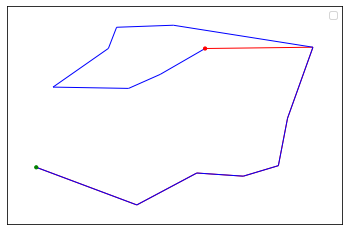

Dijkstra path : [32, 25, 20, 17, 14, 35, 47, 41]
NN path : [32, 16, 3, 46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 41]

The model is able to find a different path between 9 and 26


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


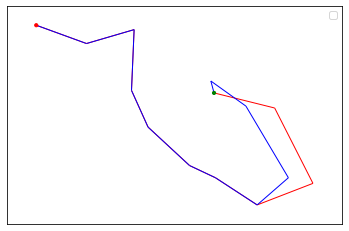

Dijkstra path : [9, 21, 47, 40, 10, 12, 7, 19, 22, 33, 26]
NN path : [9, 21, 47, 40, 10, 12, 7, 19, 43, 38, 39, 26]

The model is able to find a different path between 12 and 3


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


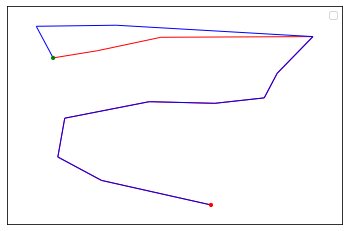

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [12, 10, 40, 47, 35, 14, 17, 20, 25, 32, 16, 3]
NN path : [12, 10, 40, 47, 35, 14, 17, 20, 25, 0, 31, 3]

The model is able to find a different path between 32 and 6


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


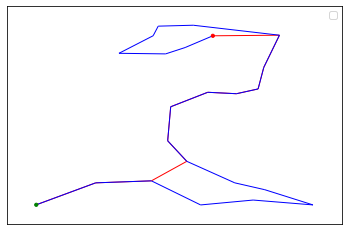

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [32, 25, 20, 17, 14, 35, 47, 40, 10, 5, 36, 6]
NN path : [32, 16, 3, 46, 28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10, 12, 7, 19, 24, 18, 5, 36, 6]

The model is able to find a different path between 16 and 44


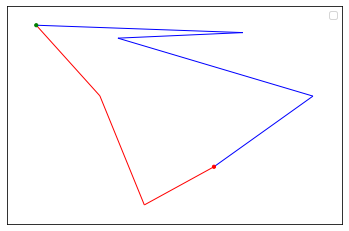

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [16, 3, 28, 44]
NN path : [16, 32, 31, 0, 44]

The model is able to find a different path between 44 and 16


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


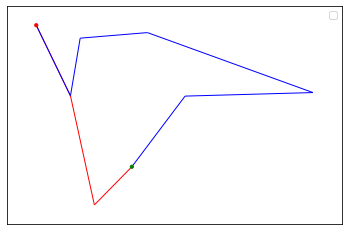

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [44, 28, 3, 16]
NN path : [44, 28, 31, 0, 25, 32, 16]

The model is able to find a different path between 31 and 10


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


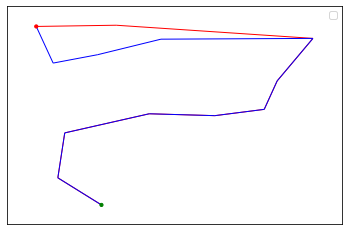

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [31, 0, 25, 20, 17, 14, 35, 47, 40, 10]
NN path : [31, 3, 16, 32, 25, 20, 17, 14, 35, 47, 40, 10]

The model is able to find a different path between 34 and 0


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


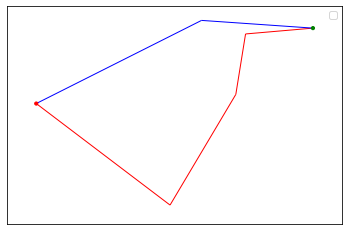

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


Dijkstra path : [34, 46, 28, 31, 0]
NN path : [34, 44, 0]

The model is able to find a different path between 28 and 18


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


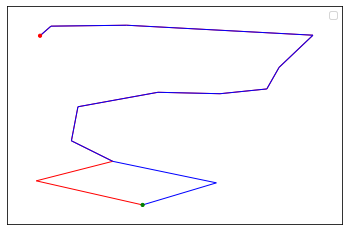

Dijkstra path : [28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10, 5, 18]
NN path : [28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10, 12, 18]



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


26   0   33
The model is able to find a different path between 12 and 36


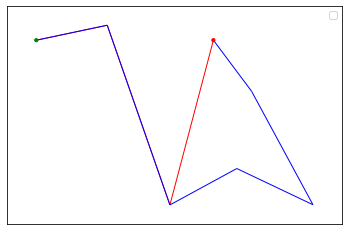

Dijkstra path : [12, 18, 5, 36]
NN path : [12, 7, 19, 24, 18, 5, 36]



The model is able to find a different path between 3 and 33


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


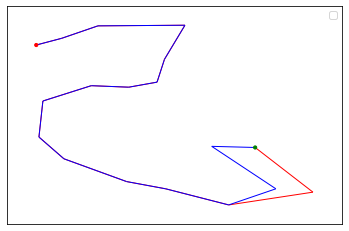

Dijkstra path : [3, 16, 32, 25, 20, 17, 14, 35, 47, 40, 10, 12, 7, 19, 22, 33]
NN path : [3, 16, 32, 25, 20, 17, 14, 35, 47, 40, 10, 12, 7, 19, 43, 38, 33]



39   2   49
The model is able to find a different path between 49 and 46


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


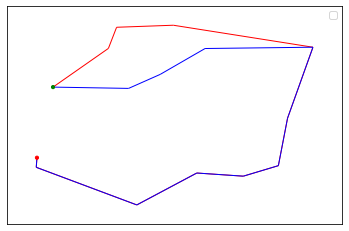

Dijkstra path : [49, 41, 47, 35, 14, 17, 20, 25, 0, 31, 28, 46]
NN path : [49, 41, 47, 35, 14, 17, 20, 25, 32, 16, 3, 46]



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


The model is able to find a different path between 44 and 10


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


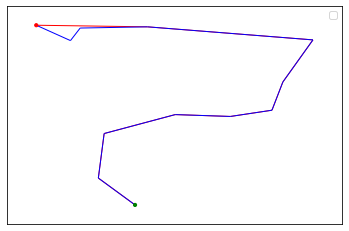

Dijkstra path : [44, 0, 25, 20, 17, 14, 35, 47, 40, 10]
NN path : [44, 28, 31, 0, 25, 20, 17, 14, 35, 47, 40, 10]

96 out of 100 can find path: 0.960000
62 out of 96 can find optimal path: 0.645833
62 out of 100 all paths can find optimal paths: 0.620000
96 pairs, μ=0.941143, σ=0.182163
96 pairs, μ=0.927664, σ=0.149855
Overall efficiency=  0.9465277832452805


In [ ]:
num_node_pairs = 100

_, _, G_test, pair_path_dict = generate_samples_from_graph(num_node_pairs=num_node_pairs,\
                                                           graph_size=50,\
                                                           augmentation=False,\
                                                           label='Test')

print_paths_statistics(G=G_test,\
                       num_to_test=num_node_pairs,\
                       pair_path_dict=pair_path_dict,
                       verbose=True)